In [1]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_colwidth', 100)

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

import re
import string
import nltk
import xgboost

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV

import sys
if not 'Notebooks/Individual/Jake' in sys.path:
    sys.path.append('Notebooks/Individual/jake')
from functions import ScoreModel, CleanText

import IPython
sound_file = '../../../data/sounds/puzzle_solved_jingle.wav'

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, plot_confusion_matrix

from textblob import TextBlob, Word
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hoogs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hoogs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv("../../../data/main.csv")
data.head()

,review,voted_up
0,"This game is fun, but it's way too easy. I couldn't believe how easy the bosses were. They look ...",1
1,Really fun and well designed.. would love to see more classes and a coop mode in the future!,1
2,Jungle people very angry.,1
3,dicksizw,1
4,As long as you dont come in expecting Dark Souls level competence you can have fun with this gam...,1


In [3]:
data["voted_up"] = data["voted_up"].astype(int)

data.head()

,review,voted_up
0,"This game is fun, but it's way too easy. I couldn't believe how easy the bosses were. They look ...",1
1,Really fun and well designed.. would love to see more classes and a coop mode in the future!,1
2,Jungle people very angry.,1
3,dicksizw,1
4,As long as you dont come in expecting Dark Souls level competence you can have fun with this gam...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21046 entries, 0 to 21045
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   review    21046 non-null  object
 1   voted_up  21046 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 246.8+ KB


In [5]:
data["voted_up"].value_counts(normalize=True)

0    0.503279
1    0.496721
Name: voted_up, dtype: float64

In [6]:
data['clean_review'] = data['review'].apply(lambda x: CleanText(x.lower()))

data.head(10)

,review,voted_up,clean_review
0,"This game is fun, but it's way too easy. I couldn't believe how easy the bosses were. They look ...",1,"[game, fun, way, easy, couldnt, believe, easy, boss, look, intimitating, first, attack, roll, wa..."
1,Really fun and well designed.. would love to see more classes and a coop mode in the future!,1,"[really, fun, well, designed, would, love, see, class, coop, mode, future]"
2,Jungle people very angry.,1,"[jungle, people, angry]"
3,dicksizw,1,[dicksizw]
4,As long as you dont come in expecting Dark Souls level competence you can have fun with this gam...,1,"[long, dont, come, expecting, dark, soul, level, competence, fun, game, would, recommend, paying..."
5,I'm in love ... <3,1,"[im, love, 3]"
6,fun asf,1,"[fun, asf]"
7,It is hard not to enjoy this game.\r\n\r\nGreat game but it's best to get it while it is on sale.,1,"[hard, enjoy, game, great, game, best, get, sale]"
8,game of the year fuck sekiro and those other games to bad its in the backlog,1,"[game, year, fuck, sekiro, game, bad, backlog]"
9,The captain honestly inspired me to be a new man.,1,"[captain, honestly, inspired, new, man]"


In [7]:
df_down = data.loc[data['voted_up'] == 0]
df_up = data.loc[data['voted_up'] == 1]

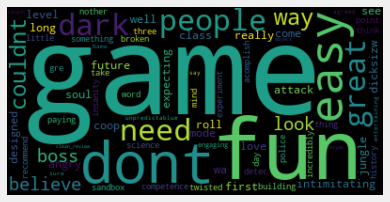

<Figure size 1440x720 with 0 Axes>

In [8]:
wordcloud = WordCloud(max_words=100, width=400, height=200).generate(str(df_up["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

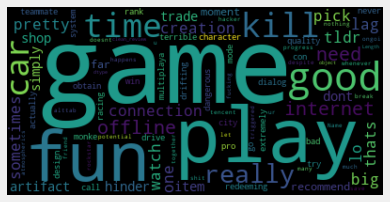

<Figure size 1440x720 with 0 Axes>

In [9]:
wordcloud = WordCloud(max_words=100, width=400, height=200).generate(str(df_down["clean_review"]))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure(figsize=(20,10))
plt.show()

In [10]:
vector = TfidfVectorizer(analyzer=CleanText, ngram_range=(2, 2))
X = vector.fit_transform(data["review"])

X_df = pd.DataFrame(X.toarray())
X_df.columns = vector.get_feature_names()
X_df.head(3)

,,0,00,000,000001,00001010,001,0010,00100000,00100111,...,𝓞𝓷,𝓨𝓞𝓤,𝕬,𝖇𝖊,𝖑𝖊𝖘𝖘,𝖑𝖎𝖙𝖙𝖑𝖊,𝖑𝖔𝖓𝖊𝖑𝖞,𝖙𝖔𝖌𝖊𝖙𝖍𝖊𝖗,𝖙𝖔𝖌𝖊𝖙𝖍𝖊𝖗codecode,𝙁𝙄𝙂𝙃𝙏
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#X = X_df.drop("user_suggestion", axis = 1, inplace=True)
y = data["voted_up"]

X_train, X_test, y_train, y_test = train_test_split(X_df, y, random_state=57, test_size=0.5)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=57, test_size=0.3)

In [12]:
baseline = RandomForestClassifier(n_estimators=100)
baseline.fit(X_train, y_train)

RandomForestClassifier()

In [13]:
ScoreModel(baseline, X_train, y_train)

Accuracy:   0.9928727549177991
F1 Score:   0.9929225252429933
Recall:     0.994894099848714
Precision:  0.9909587492936522
ROC_AUC:    0.9928625227037268


In [15]:
ScoreModel(baseline, X_test, y_test)

Accuracy:   0.7794355221894896
F1 Score:   0.7588070248363298
Recall:     0.7067363530778165
Precision:  0.8191608705407225
ROC_AUC:    0.7781395037743013


In [16]:
IPython.display.Audio(sound_file, autoplay=True, rate=1000)